# OpenEO for ESA CCI Fire Data

The Fire collections can be browsed using the CCI STAC browser at https://radiantearth.github.io/stac-browser/#/external/api.stac.164.30.69.113.nip.io/collections/cci_openeo, where we can see there are 3 individual OpenEO data cubes corresponding to three Fire data product DRS'. A list of these can be found below (as of 29/09/2025)

- ESACCI-L3S_FIRE-BA-AVHRR-LTDR-fv1.1.openeo
- ESACCI-L3S_FIRE-BA-SYN-fv1.1.openeo
- ESACCI.FIRE.mon.L3S.BA.MSI-Sentinel-2.Sentinel-2A.MSI.2-0.pixel.openeo

For more info on local processing with OpenEO visit: https://open-eo.github.io/openeo-python-client/cookbook/localprocessing.html

## OpenEO Local Processing

Make sure you have used one of the requirements files from this repository (either for python3.10 or python3.11) to install all necessary packages for OpenEO local processing.

First we import the local connection processor from OpenEO and configure for local processing. We can also import matplotlib for plotting some example data later.

In [1]:
from openeo.local import LocalConnection
import matplotlib.pyplot as plt

connection = LocalConnection('./')

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


Then we can configure for the CCI OpenEO endpoint using the following cell. Note that we have selected a specific DRS from the options above, which are also listed in the STAC browser at the URL above.

In [2]:
url = 'https://api.stac.164.30.69.113.nip.io/collections/ESACCI-L3S_FIRE-BA-SYN-fv1.1.openeo'
url = url.lower()

# Queensland Australia
spatial_extent = {'north':-14, 'south':-38, 'west': 138, 'east': 154}
temporal_extent = ['2019-01-01','2019-12-31']


datacube = connection.load_stac(url=url, bands=['LC', 'JD', 'CL'], spatial_extent=spatial_extent, temporal_extent=temporal_extent)
dataset = datacube.execute()

A few things to note with the above code. The DRS syntax found across other CCI sites needs to be lower-case to work as the ID of a STAC collection, hence the need for the `.lower()` method. This is crucial for access as the capitalised version will not connect.

The selections applied here for spatial and temporal extents MUST be applied before the datacube is `executed`, otherwise Dask will attempt to reserve memory for the entire collection!

In addition, the bands specified here can be found in the collection page's `Spectral Bands` section if you scroll down on the browser. Currently these are required to inform the openEO client about which data assets you're trying to load. If these are not specified you will be met by an error message stating the current limitation that OpenEO cannot load a collection without specifying the current bands. OpenEO will let you know the available bands if you provide any incorrect value to bands.

In this case the bands correspond to:
- LC: Land Cover for burned area
- JD: Julian date for recordings
- CL: Calibration value.

We are then able to execute our datacube selection and receive an xarray dataset object, as seen below:

In [3]:
dataset

<xarray.DataArray (bands: 3, time: 12, latitude: 8640, longitude: 5760)> Size: 7GB
dask.array<getitem, shape=(3, 12, 8640, 5760), dtype=float32, chunksize=(1, 1, 8640, 5760), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 69kB -14.0 -14.0 -14.01 ... -38.0 -38.0
  * longitude    (longitude) float64 46kB 138.0 138.0 138.0 ... 154.0 154.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 96B 2019-01-01 2019-02-01 ... 2019-12-01
  * bands        (bands) object 24B 'LC' 'JD' 'CL'

From this dataset we can select the band belonging to Land Cover. For further descriptive information about the meaning of the bands, please see the info and documentation linked from the STAC collection to CEDA Catalogue Record for this product. A product user guide and other information is listed there.

We also perform a mean along the monthly time slices for this record.


In [4]:
fire = dataset.sel(bands='LC').mean(dim='time')
fire

<xarray.DataArray (latitude: 8640, longitude: 5760)> Size: 199MB
dask.array<mean_agg-aggregate, shape=(8640, 5760), dtype=float32, chunksize=(8640, 5760), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 69kB -14.0 -14.0 -14.01 ... -38.0 -38.0
  * longitude    (longitude) float64 46kB 138.0 138.0 138.0 ... 154.0 154.0
    spatial_ref  int32 4B 4326
    bands        <U2 8B 'LC'

Finally we can plot the data for Land Cover (customisations via matplotlib are possible here, See the [matplotlib documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) for a full description of how to customise the plot.)

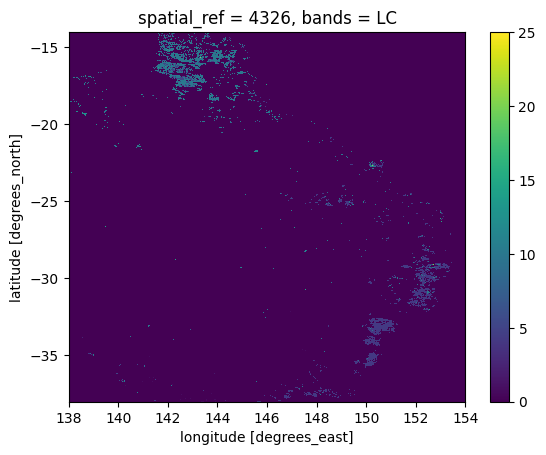

In [5]:
fire.plot()